In [1]:
using PyPlot
using Random
using Distributions
using JuMP, Ipopt

In [2]:
include("../src/model.jl");
include("../src/ensemble.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");

In [3]:
# Model domain
dt = 1.
t = Array(2020:dt:2200);

GWP = 100. # global world product (trillion $ / year)

β = 0.02*GWP/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.025 # ρ (relative low value from Stern review)

# Control technology cost scales (for full deployment, α=1.)
reduce_cost = 0.01*GWP;
remove_cost = 0.02*GWP;
geoeng_cost = 0.05*GWP;
adapt_cost = 0.03*GWP;

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0.,
    baseline_emissions(t)
)

Economics(0.2222222222222222, 0.025, 1.0, 2.0, 5.0, 3.0, 0.0, 0.0, 0.0, 0.0, [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [4]:
Random.seed!(1)
d = Normal(0.65, 0.13)
feedback_samples = rand(d, 100)
feedback_samples[feedback_samples .>= 0.999] .= NaN
feedback_samples[feedback_samples .<= 0.] .= NaN

ECS₀ = 1.2
ECS_samples = ECS₀ ./ (1. .-feedback_samples);

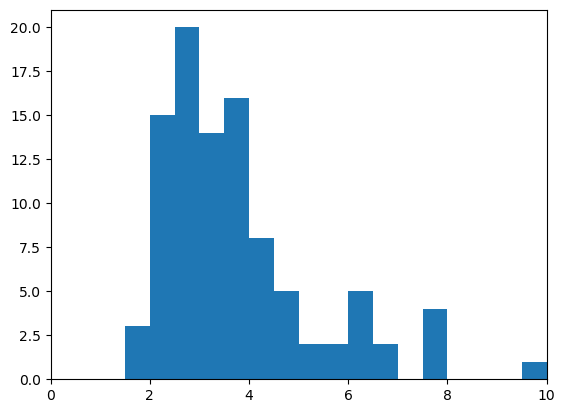

(0, 10)

In [5]:
hist(ECS_samples, bins=0.:0.5:20.)
xlim([0,10])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2776
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1981

Total number of variables............................:     1621
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1440
                     variables with only upper bounds:        0
Total number of equ

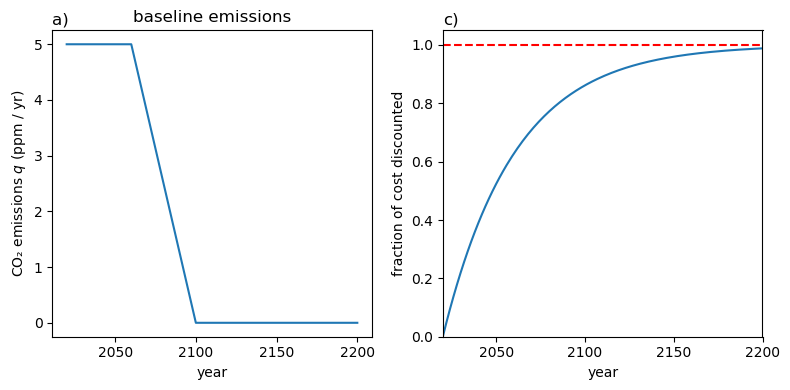

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2776
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1981

Total number of variables............................:     1621
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1440
                     variables with only upper bounds:        0
Total number of equality constraints.................:      901
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [6]:
maxslope = 1. /30.

ensemble = Dict{String, ClimateModel}();
first = true

for member_id in 1:length(ECS_samples)
    present_year = 2020.
    ECS = ECS_samples[member_id]
    name = "member $member_id";
    controls = init_linear_controls(t);
    model = ClimateModel(name, ECS, t, dt, controls, economics, present_year);
    optimize_controls!(model, maxslope=maxslope)
    
    if CO₂(model)[end-1] < 1.e5
        ensemble[name] = model
    end
        
    if first; plot_setup(model); first=false; end
end

()()()()()()()()

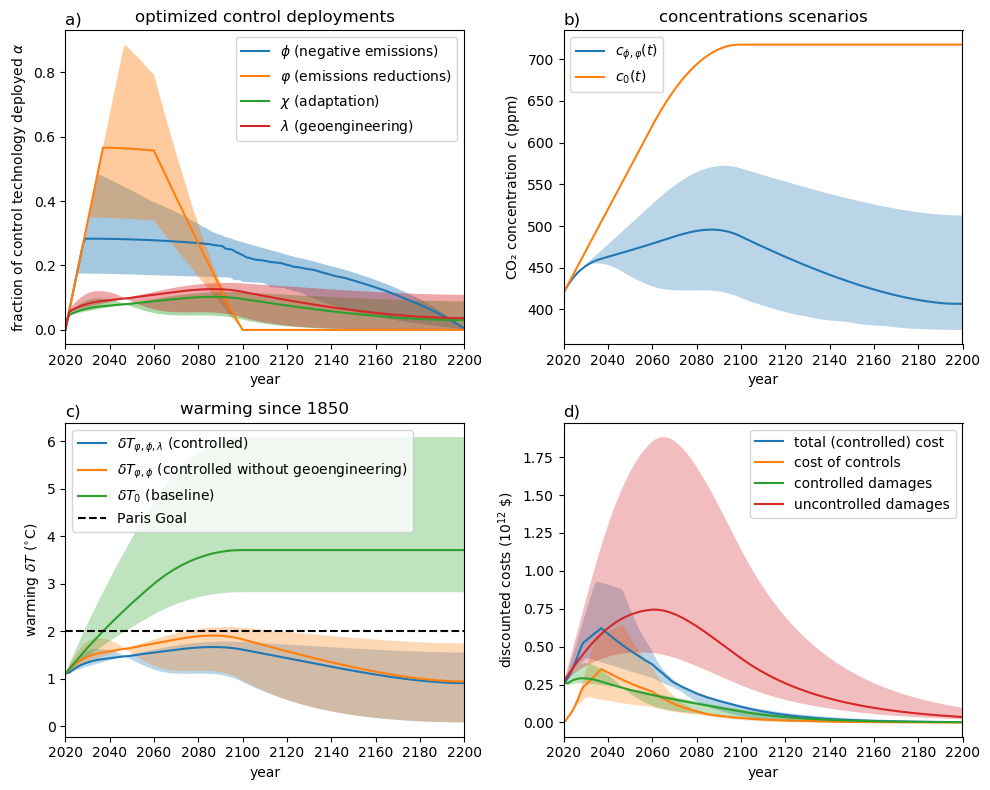

()

In [7]:
plot_ensemble_stats(ensemble, t)

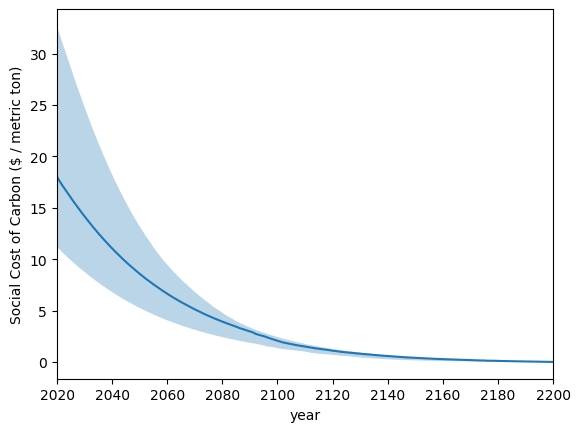

PyObject Text(24.000000000000014, 0.5, 'Social Cost of Carbon ($ / metric ton)')

In [8]:
SCCs = zeros(size(t)..., 3)
for (idx, year) in enumerate(t)
    first, median, ninth = ensemble_diagnostic_statistics_scalar(ensemble, SCC, t, year)
    SCCs[idx,1] = first;
    SCCs[idx,2] = median;
    SCCs[idx,3] = ninth;
end

fill_between(t, SCCs[:,1], SCCs[:,3], facecolor="C0", alpha=0.3)
plot(t, SCCs[:,2], "C0-", label="total (controlled) cost")
xlim(t[1], t[end])
xlabel("year")
ylabel("Social Cost of Carbon (\$ / metric ton)")